# Speech Sample Analysis

This notebook goes through a simple analysis of a single speech sample

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from speechbrain.processing.voice_analysis import *

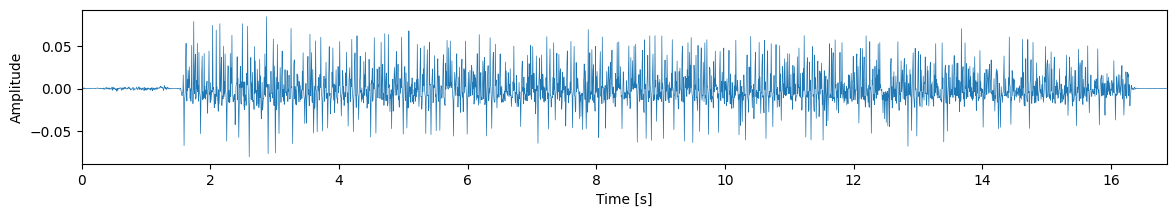

In [2]:
# Load sustained phonation recording from QPN dataset
audio_filename = "qpn_PD00020_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Parameters for all figures in the document
plt.rcParams["figure.figsize"] = (14,2)
plt.rcParams['axes.xmargin'] = 0

# Downsample to reduce number of points on the plot
downsample_factor = 100
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Intro

To understand how this speech analysis works, we'll step through the `vocal_characteristics` function. The very fist lines
just set up the variables needed for computation

In [3]:
# Frequency of human speech is usually between 75-300 Hz
min_f0_Hz = 75
max_f0_Hz = 300

# A new window of 0.04 second length every 0.01 seconds
step_size = 0.01
window_size = 0.04

# Do some number manipulations
step_samples = int(step_size * sample_rate)
window_samples = int(window_size * sample_rate)
max_lag_samples = int(sample_rate / min_f0_Hz)
min_lag_samples = int(sample_rate / max_f0_Hz)

print("Samples between (the start of) one frame and the next:", step_samples)
print("Samples contained within each frame:", window_samples)
print("Number of samples in the maximum lag:", max_lag_samples)
print("Number of samples in the minimum lag:", min_lag_samples)

Samples between (the start of) one frame and the next: 160
Samples contained within each frame: 640
Number of samples in the maximum lag: 213
Number of samples in the minimum lag: 53


Our sanity check for these values is that at least one complete period will be contained in the frame (for minimum Hz) and at most 8 for maximum Hz.

## Getting voiced portion

In order to do a f0 analysis, we have to figure out which portions are harmonic. We use both autocorrelation and jitter (as in PRAAT).

Autocorrelation is the cross-correlation of a signal with itself at various lags.
For harmonic signals, there are peaks at regular intervals corresponding to the period.
The autocorrelation ratio is the ratio of the strongest peak against the theoretical maximum
which occurs when the lag is zero.

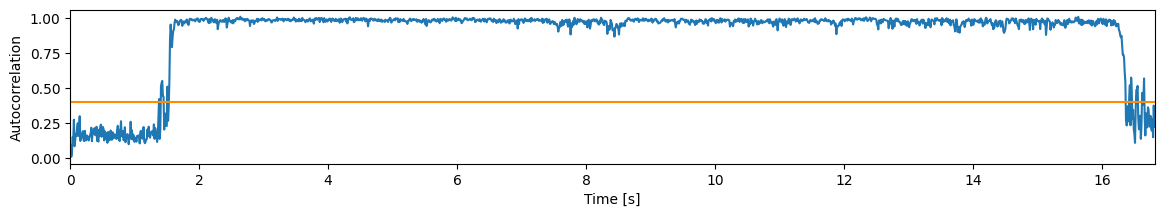

In [4]:
kbest_lags, autocorrelation_ratio, hnr = autocorrelate(
    audio, step_samples, window_samples, min_lag_samples, max_lag_samples
)

autocorrelation_threshold = 0.4
#plt.plot(xs, power_ratio, color="lightblue")
xs = torch.arange(len(autocorrelation_ratio)) * step_size
plt.plot(xs, autocorrelation_ratio)
plt.xlabel("Time [s]")
plt.ylabel("Autocorrelation")
plt.axhline(y = autocorrelation_threshold, color="darkorange")
plt.show()

In addition, PRAAT marks all frames as unvoiced that exceed a certain jitter threshold, by default 2 percent. We'll estimate jitter using our initial data.

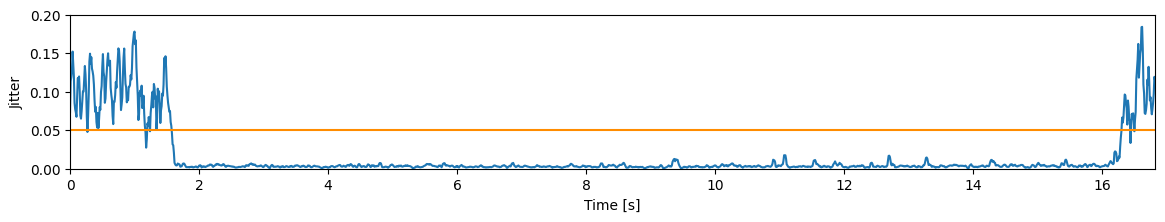

In [5]:
jitter, shimmer = compute_periodic_features(audio.squeeze(), kbest_lags[:, 0])
jitter_threshold = 0.05
#plt.plot(xs, autocorrelation_ratio, color="lightblue")
plt.plot(xs, jitter)
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.ylim((0, 0.2))
plt.axhline(y = jitter_threshold, color="darkorange")
plt.show()

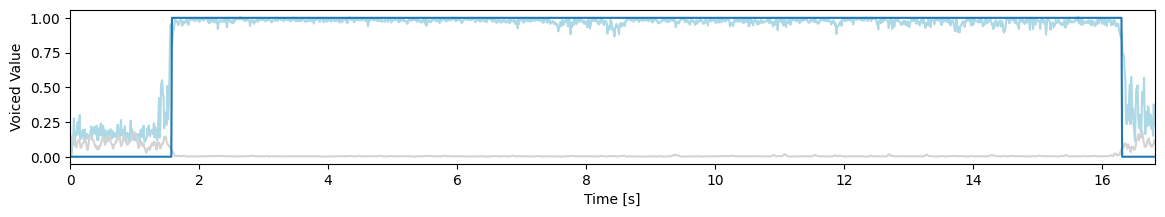

In [6]:
# voicing threshold is simply the intersection of these thresholds.
voiced = autocorrelation_ratio > autocorrelation_threshold
voiced &= jitter < jitter_threshold
voiced = neighbor_average(voiced.float(), neighbors=21).round().bool()

plt.plot(xs, autocorrelation_ratio, color="lightblue")
plt.plot(xs, jitter, color="lightgrey")
plt.plot(xs, voiced)
plt.xlabel("Time [s]")
plt.ylabel("Voiced Value")
plt.show()

## Computing vocal characteristics

Common vocal characteristics are jitter, shimmer, and harmonic-to-noise ratio. We just saw Jitter

Average jitter: 0.38%


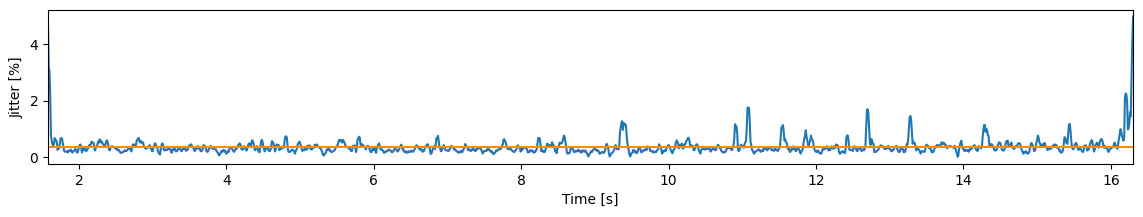

In [7]:
plt.plot(xs[voiced], 100 * jitter[voiced])
plt.xlabel("Time [s]")
plt.ylabel("Jitter [%]")
plt.axhline(y = 100 * jitter[voiced].mean(), color="darkorange")
print("Average jitter: {:.2f}%".format(jitter[voiced].mean() * 100))

Average shimmer: 1.90%


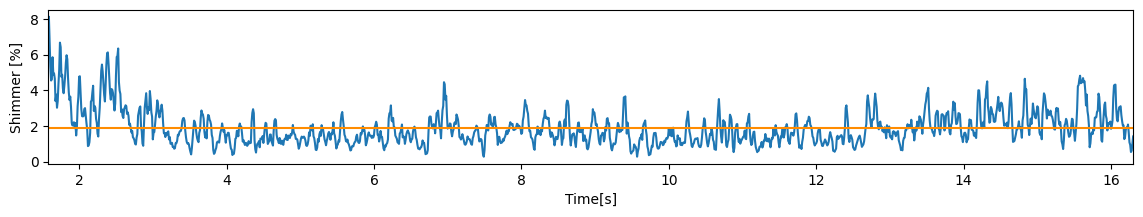

In [8]:
plt.plot(xs[voiced], 100 * shimmer[voiced])
plt.axhline(y=100 * shimmer[voiced].mean(), color="darkorange")
plt.xlabel("Time[s]")
plt.ylabel("Shimmer [%]")
print("Average shimmer: {:.2f}%".format(shimmer[voiced].mean() * 100))

tensor(17.2809)


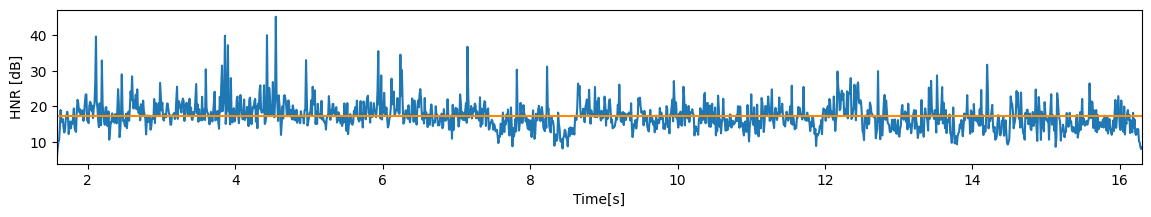

In [9]:
plt.plot(xs[voiced], hnr[voiced])
plt.axhline(y=hnr[voiced].nanmean(), color="darkorange")
plt.xlabel("Time[s]")
plt.ylabel("HNR [dB]")
print(hnr[voiced].nanmean())

## Computing f0

The fundamental frequency, f0, is the period of the waveform. This is computed by taking the
k-best lags from the autocorrelation and comparing to neighboring frames to avoid octave errors.

Estimated average frequency: 122.7 Hz


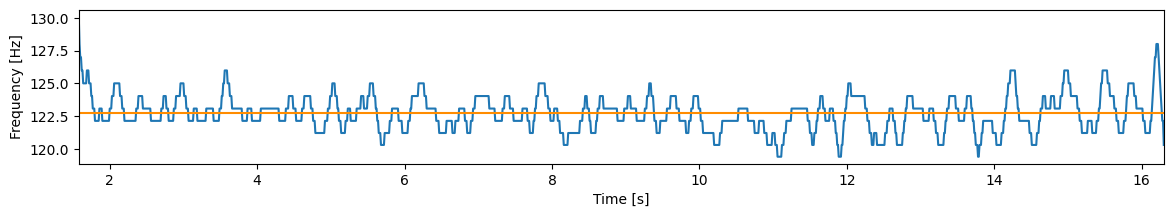

In [10]:
# Only compute f0 on voiced frames, it doesn't make sense on unvoiced ones.
best_lags = iterative_lag_selection(kbest_lags[voiced], iterations=3)

# Convert to hZ
estimated_f0 = sample_rate / best_lags

#voiced_xs = xs[voiced]
plt.plot(xs[voiced], estimated_f0)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.axhline(y = estimated_f0.mean(), color="darkorange")
print("Estimated average frequency: {0:.1f} Hz".format(estimated_f0.mean().numpy()))

In [11]:
# Of course this can all be done in one step
f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio.squeeze(), sample_rate=sample_rate)

## PRAAT-Parselmouth

We'll run a similar analysis to verify that our numbers look accurate.

In [12]:
import parselmouth
from parselmouth.praat import call
import numpy as np

# Bundle these to compute them again later
def compute_praat_features(audio_filename):
    f0min = 75
    f0max = 300
    
    sound = parselmouth.Sound(audio_filename)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan

    jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

    harmonicity = sound.to_harmonicity()

    return pitch.xs(), pitch_values, jitter, shimmer, harmonicity


pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

Estimated average frequency (SpeechBrain): 122.7 Hz
Estimated average frequency (PRAAT): 122.7 Hz


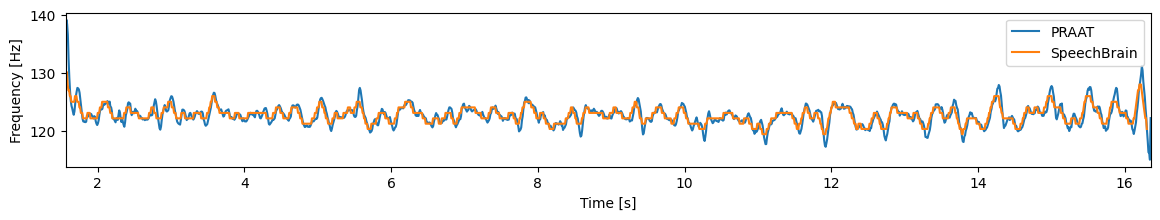

In [13]:
# Pitch comparison
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced], f0)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])

print("Estimated average frequency (SpeechBrain): {0:.1f} Hz".format(estimated_f0.mean().numpy()))
print("Estimated average frequency (PRAAT): {0:.1f} Hz".format(np.nanmean(pitch_values)))

In [14]:
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * jitter[voiced].mean().numpy()))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Jitter (SpeechBrain): 0.38%
Average Jitter (PRAAT): 0.23%


In [15]:
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average Shimmer (SpeechBrain): 1.90%
Average Shimmer (PRAAT): 1.54%


Average HNR (SpeechBrain): 17.3%
Average HNR (PRAAT): 19.3%


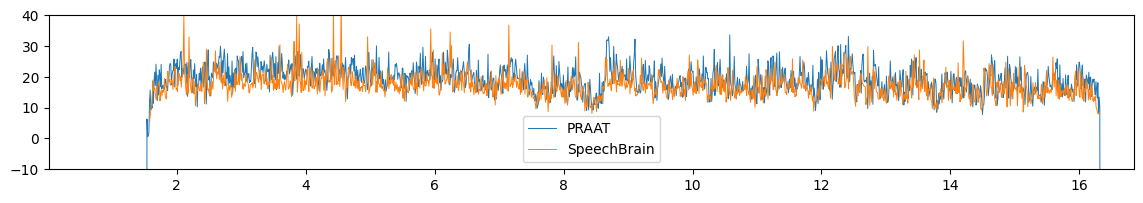

In [16]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T, linewidth=0.7)
plt.plot(xs[voiced], hnr[voiced], linewidth=0.7)
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[voiced].nanmean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

## Difficult Example

To further verify that we are able to closely match the PRAAT vocal characteristics, we compute the same statistics for a more difficult example. The "voiced" and pitch computation is very difficult, even ambiguous, in this example due to numerous voice breaks. However, we want to at least show similar jitter, shimmer, and hnr values.

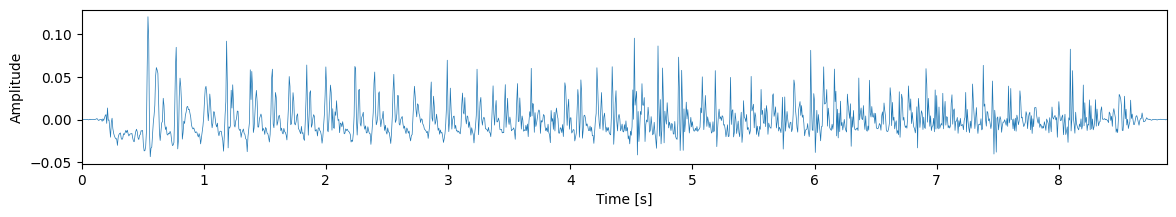

In [17]:
audio_filename = "qpn_MNI0144_a1.wav"
audio, sample_rate = torchaudio.load(audio_filename)

# Downsample to reduce number of points on the plot
downsample_factor = 100
xs = torch.arange(len(audio[0,::downsample_factor])) / sample_rate * downsample_factor
plt.plot(xs, audio[0,::downsample_factor], linewidth=.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

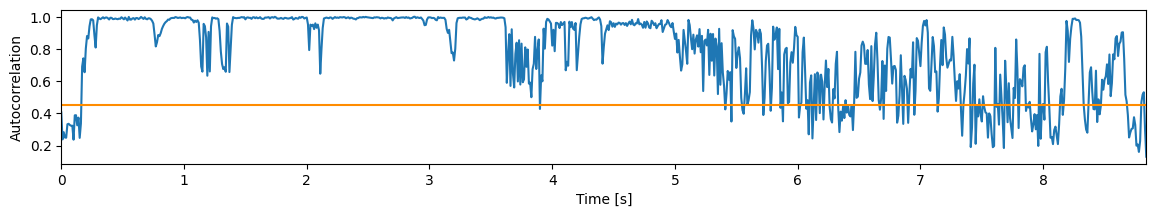

In [18]:
kbest_lags, autocorrelation_ratio, hnr = autocorrelate(
    audio, step_samples, window_samples, min_lag_samples, max_lag_samples
)

autocorrelation_threshold = 0.45
xs = torch.arange(len(autocorrelation_ratio)) * step_size
plt.plot(xs, autocorrelation_ratio)
plt.xlabel("Time [s]")
plt.ylabel("Autocorrelation")
plt.axhline(y = autocorrelation_threshold, color="darkorange")
plt.show()

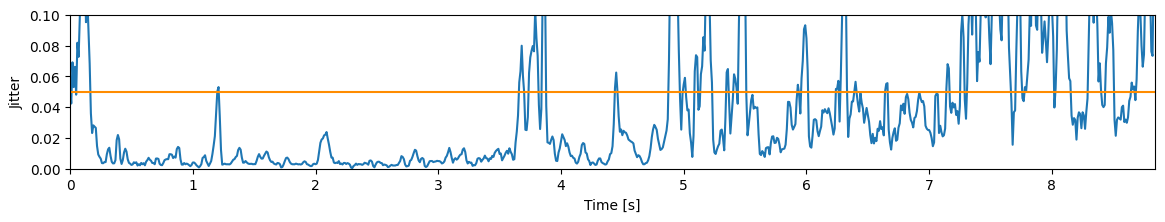

In [19]:
jitter, shimmer = compute_periodic_features(audio.squeeze(), kbest_lags[:, 0])
plt.plot(xs, jitter)
plt.xlabel("Time [s]")
plt.ylabel("Jitter")
plt.ylim((0, 0.1))
plt.axhline(y = jitter_threshold, color="darkorange")
plt.show()

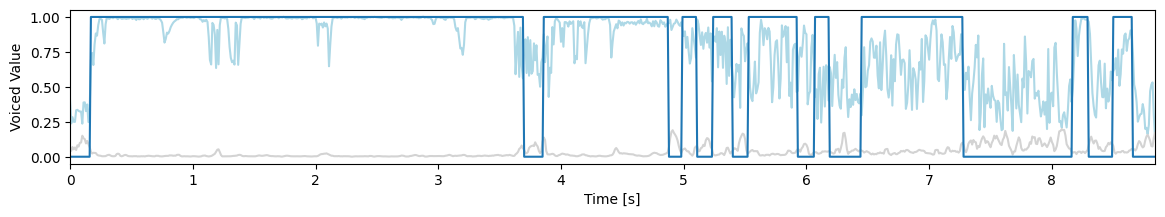

In [20]:
# voicing threshold is simply the intersection of these thresholds.
voiced = autocorrelation_ratio > autocorrelation_threshold
voiced &= jitter < jitter_threshold
voiced = neighbor_average(voiced.float(), neighbors=15).round().bool()

plt.plot(xs, autocorrelation_ratio, color="lightblue")
plt.plot(xs, jitter, color="lightgrey")
plt.plot(xs, voiced)
plt.xlabel("Time [s]")
plt.ylabel("Voiced Value")
plt.show()

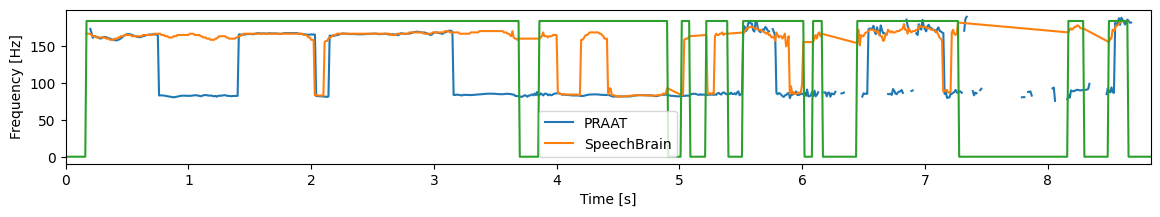

In [21]:
estimated_f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio.squeeze(), sample_rate=sample_rate)
pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(audio_filename)

xs = torch.arange(len(voiced)) * step_size
plt.plot(pitch_xs, pitch_values)
plt.plot(xs[voiced], estimated_f0)
plt.plot(xs, voiced.float() * estimated_f0.max())
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.legend(["PRAAT", "SpeechBrain"])
plt.show()

Average Jitter (SpeechBrain): 1.71%
Average Jitter (PRAAT): 0.84%


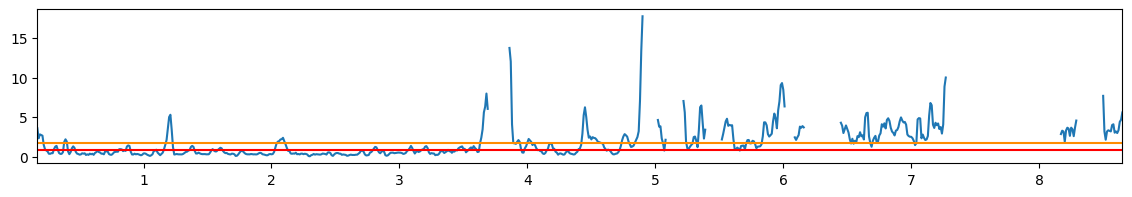

In [22]:
sb_jitter = jitter[voiced].mean().numpy()
jitter[~voiced] = np.nan
plt.plot(xs, 100 * jitter)
plt.axhline(y=100 * sb_jitter, color="darkorange")
plt.axhline(y=100 * praat_jitter, color="red")
print("Average Jitter (SpeechBrain): {0:.2f}%".format(100 * sb_jitter))
print("Average Jitter (PRAAT): {0:.2f}%".format(100 * praat_jitter))

Average Shimmer (SpeechBrain): 14.12%
Average Shimmer (PRAAT): 3.96%


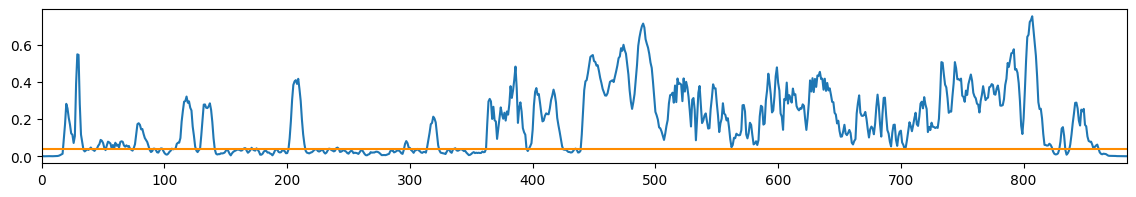

In [23]:
plt.plot(shimmer)
plt.axhline(y=praat_shimmer, color="darkorange")
print("Average Shimmer (SpeechBrain): {0:.2f}%".format(100 * shimmer[voiced].mean().numpy()))
print("Average Shimmer (PRAAT): {0:.2f}%".format(100 * praat_shimmer))

Average HNR (SpeechBrain): 14.3%
Average HNR (PRAAT): 15.1%


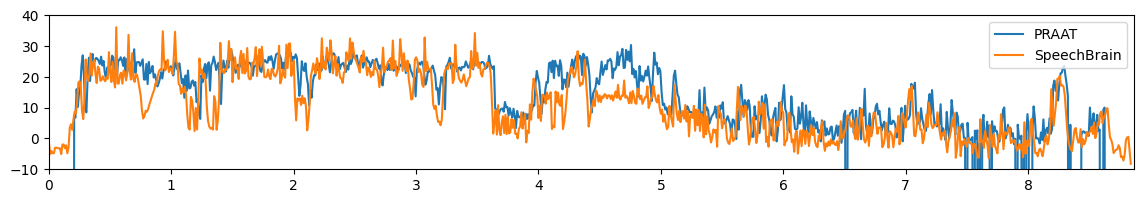

In [24]:
praat_hnr = call(harmonicity, "Get mean", 0, 0)
plt.plot(harmonicity.xs(), harmonicity.values.T)
plt.plot(xs, hnr)
plt.ylim((-10, 40))
plt.legend(["PRAAT", "SpeechBrain"])
print("Average HNR (SpeechBrain): {0:.1f}%".format(hnr[voiced].mean().numpy()))
print("Average HNR (PRAAT): {0:.1f}%".format(praat_hnr))

In [25]:
# The difference in HNR is attributable to the fact that PRAAT computes the value even in unvoiced regions
# PRAAT tensor is shorter by one, add a value to the voiced array
voiced = torch.nn.functional.pad(voiced, (0, 1)).numpy()
print("Average HNR (PRAAT, voiced): {0:.1f}%".format(harmonicity.values.T[voiced].mean()))

Average HNR (PRAAT, voiced): 14.7%


## Stats over QPN dataset

We show the stats are similar when computed over the full dataset too.

In [26]:
from getpass import getpass

data_folder = getpass("Enter data folder:")

Enter data folder: ········


In [27]:
import glob
import time
import os

samples = {}
sb_jitters, sb_shimmers, sb_hnrs = [], [], []
praat_jitters, praat_shimmers, praat_hnrs = [], [], []
for filename in glob.glob(data_folder + "/Batch[12]/Segmented/*_a[123].wav"):
    audio, sample_rate = torchaudio.load(filename)

    basename = os.path.basename(filename)
    _, pid, trial = basename[:-len(".wav")].split("_")


    try:
        start = time.time()
        estimated_f0, voiced, jitter, shimmer, hnr = vocal_characteristics(audio.squeeze(), sample_rate=sample_rate)
        sb_end = time.time()
        pitch_xs, pitch_values, praat_jitter, praat_shimmer, harmonicity = compute_praat_features(filename)
        praat_end = time.time()
    except RuntimeError as e:
        kbest_lags, autocorrelation_ratio, hnr = autocorrelate(
            audio, step_samples, window_samples, min_lag_samples, max_lag_samples
        )
        jitter, shimmer = compute_periodic_features(audio.squeeze(), kbest_lags[:, 0])
        voiced = autocorrelation_ratio > 0.4
        voiced &= jitter < 0.05
        voiced = neighbor_average(voiced.float(), neighbors=15).round().bool()
        xs = torch.arange(len(voiced)) * step_size
        plt.plot(xs, autocorrelation_ratio, color="lightblue")
        plt.plot(xs, jitter, color="lightgrey")
        plt.plot(xs, voiced)
        plt.xlabel("Time [s]")
        plt.ylabel("Voiced Value")
        plt.show()
        print(filename)

        raise e


    praat_voiced = torch.nn.functional.pad(voiced, (0, 2)).numpy()
    praat_hnr = harmonicity.values.T
    praat_voiced = praat_voiced[:len(praat_hnr)]
    praat_hnr[praat_hnr < 0] = 0
    praat_hnr_voiced = praat_hnr[praat_voiced].mean()
    praat_hnr = praat_hnr.mean()
    
    if pid not in samples:
        samples[pid] = {}

    samples[pid][trial] = {
        "intensity": audio.square().mean(),
        "sb_jitter": jitter.mean(),
        "sb_jitter_voiced": jitter[voiced].mean(),
        "sb_shimmer": shimmer.mean(),
        "sb_shimmer_voiced": shimmer[voiced].mean(),
        "sb_hnr": hnr.mean(),
        "sb_hnr_voiced": hnr[voiced].mean(),
        "sb_time": sb_end - start,
        "praat_jitter": praat_jitter,
        "praat_shimmer": praat_shimmer,
        "praat_hnr": praat_hnr,
        "praat_hnr_voiced": praat_hnr_voiced,
        "praat_time": praat_end - sb_end,
    }

(0.0, 0.05)

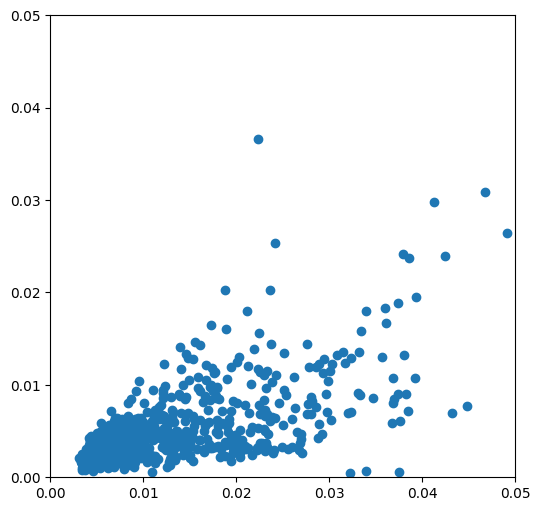

In [56]:
plt.rcParams["figure.figsize"] = (6,6)

def flatten(samples, index):
    return [samples[pid][trial][index] for pid in samples for trial in samples[pid]]
plt.scatter(flatten(samples, "sb_jitter_voiced"), flatten(samples, "praat_jitter"))
plt.xlim((0, 0.05))
plt.ylim((0, 0.05))

(0.0, 0.2)

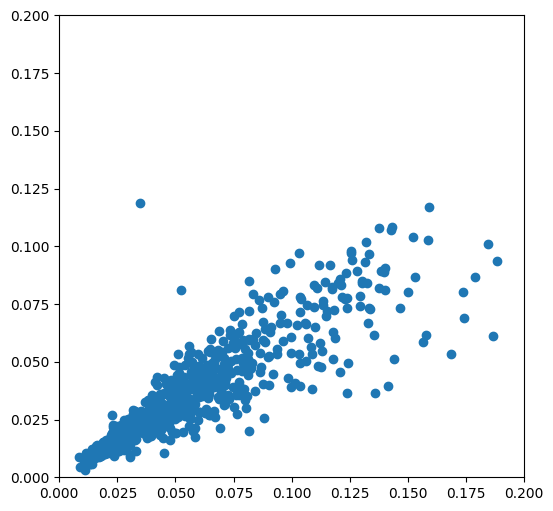

In [55]:
plt.scatter(flatten(samples, "sb_shimmer_voiced"), flatten(samples, "praat_shimmer"))
plt.ylim((0, 0.2))
plt.xlim((0, 0.2))

(-5.0, 35.0)

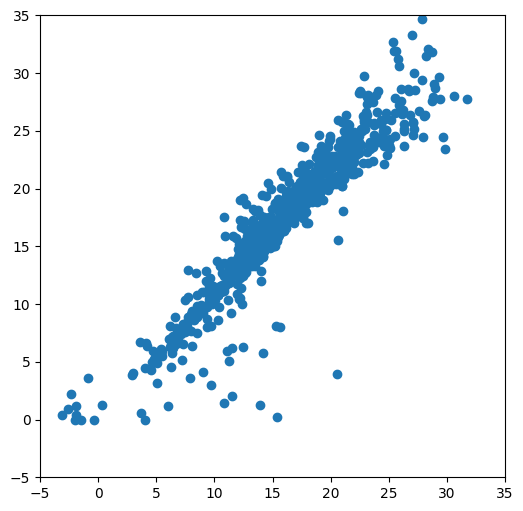

In [57]:
plt.scatter(flatten(samples, "sb_hnr_voiced"), flatten(samples, "praat_hnr_voiced"))
plt.ylim((-5, 35))
plt.xlim((-5, 35))

(array([ 34., 428., 243.,  56.,   9.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025]),
 <BarContainer object of 5 artists>)

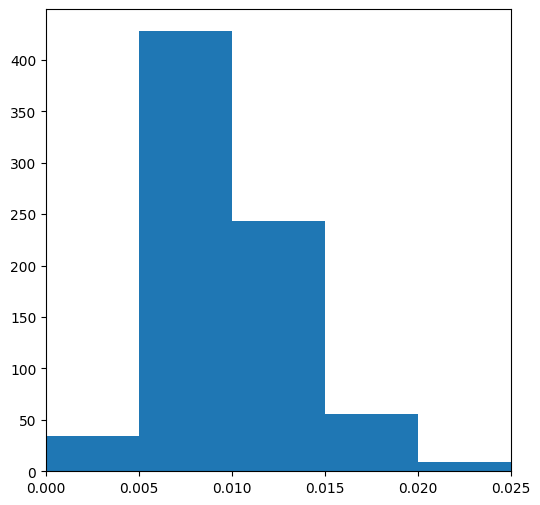

In [31]:
plt.hist(flatten(samples, "sb_time"), bins=[0, 0.005, 0.01, 0.015, 0.02, 0.025])

(array([129., 442., 151.,  45.,   8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <BarContainer object of 5 artists>)

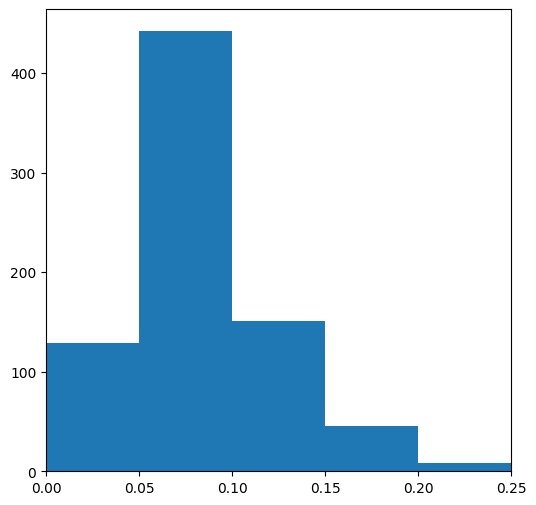

In [32]:
plt.hist(flatten(samples, "praat_time"), bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25])

## Compute predictiveness

So we will do this for both detection and regression. First separate by PD/non-PD, then correlate with functional score. 

In [33]:
import pandas

batch1 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch1.csv"), index_col=0)
batch2 = pandas.read_csv(os.path.join(data_folder, "QPN_Batch2-demographic.csv"), index_col=0)
qpn = pandas.concat([batch1, batch2]).groupby("pid").last()
qpn.replace({"CTRL": "control", "PD": "patient"}, inplace=True)
len(qpn)

276

In [34]:
xs, ys = [], []
xs2, ys2 = [], []
for pid in qpn.index:
    if qpn.loc[pid].group == "control" and pid in samples:
        for trial in samples[pid]:
            xs.append(samples[pid][trial]["sb_shimmer_voiced"])
            ys.append(samples[pid][trial]["sb_jitter_voiced"])
    elif qpn.loc[pid].group == "patient" and pid in samples:
        for trial in samples[pid]:
            xs2.append(samples[pid][trial]["sb_shimmer_voiced"])
            ys2.append(samples[pid][trial]["sb_jitter_voiced"])

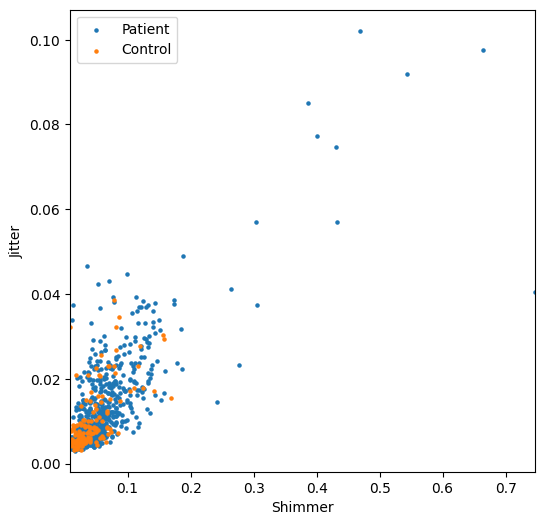

In [35]:
plt.scatter(xs2, ys2, s=5)
plt.scatter(xs, ys, s=5)
plt.xlabel("Shimmer")
plt.ylabel("Jitter")
plt.legend(["Patient", "Control"])

## XGBoost

What if we did very basic prediction

In [36]:
# Find which are test samples
test_files = glob.glob(os.path.join(data_folder, "Neuro_split", "test_*", "Batch*", "*_a1.wav"))
test_ids = [os.path.basename(f).split("_")[1] for f in test_files]
len(test_ids)

32

In [70]:
# Collect features
xs, ys = [], []
test_xs, test_ys = [], []
sys = "sb"
voiced = "_voiced"
for pid in qpn.index:
    if qpn.loc[pid].group == "control" and pid in samples:
        y = 0
    elif qpn.loc[pid].group == "patient" and pid in samples:
        y = 1
    else:
        continue

    row = [qpn.loc[pid].age]
    for trial in ["a1", "a2", "a3"]:
        if trial not in samples[pid]:
            intensity = np.mean([samples[pid][t]["intensity"] for t in samples[pid]])
            shimmer = np.mean([samples[pid][t][f"{sys}_shimmer{voiced}"] for t in samples[pid]])
            jitter = np.mean([samples[pid][t][f"{sys}_jitter{voiced}"] for t in samples[pid]])
            hnr = np.mean([samples[pid][t][f"{sys}_hnr{voiced}"] for t in samples[pid]])
        else:
            intensity = samples[pid][trial]["intensity"]
            shimmer = samples[pid][trial][f"{sys}_shimmer{voiced}"]
            jitter = samples[pid][trial][f"{sys}_jitter{voiced}"]
            if not np.isfinite(samples[pid][trial][f"{sys}_hnr{voiced}"]):
                hnr = np.mean([samples[pid][t][f"{sys}_hnr{voiced}"] for t in samples[pid] if t != trial])
            else:
                hnr = samples[pid][trial][f"{sys}_hnr{voiced}"]

        row.append(intensity)
        row.append(shimmer)
        row.append(jitter)
        row.append(hnr)

    if pid in test_ids:
        test_xs.append(row)
        test_ys.append(y)
    else:
        xs.append(row)
        ys.append(y)

In [71]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(scale_pos_weight=0.1)
xgb.fit(xs, ys)
predictions = xgb.predict(test_xs)
accuracy = accuracy_score(test_ys, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.50%


In [72]:
predictions

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0])

In [73]:
np.array(test_ys)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1])